<a href="https://colab.research.google.com/github/maame-dankwaa/Plant-Disease-Detection/blob/main/Plant_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import cv2
from PIL import Image
import os
from zipfile import ZipFile
import pickle
import json

In [74]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.1 MB/s eta 0:00:00


In [3]:
with ZipFile("/content/drive/My Drive/Afarinick Internship/archive.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
print(os.listdir('/content/'))
print()

['.config', 'PlantVillage', 'drive', 'plantvillage', 'best_model.h5', 'sample_data']



In [5]:
dataset_path = "/content/PlantVillage"
print(os.listdir(dataset_path))
print(len(os.listdir(dataset_path)))
classes = os.listdir(dataset_path)
print(f"Number of classes: {len(classes)}")
print("Classes:", classes[:10])

['Tomato_Septoria_leaf_spot', 'Pepper__bell___Bacterial_spot', 'Tomato_Leaf_Mold', 'Potato___Early_blight', 'Tomato_healthy', 'Potato___healthy', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato__Tomato_mosaic_virus', 'Tomato_Late_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Pepper__bell___healthy', 'Tomato__Target_Spot', 'Tomato_Early_blight']
15
Number of classes: 15
Classes: ['Tomato_Septoria_leaf_spot', 'Pepper__bell___Bacterial_spot', 'Tomato_Leaf_Mold', 'Potato___Early_blight', 'Tomato_healthy', 'Potato___healthy', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato__Tomato_mosaic_virus']


Data Exploration

In [6]:
class_counts = {}
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))


(256, 256, 3)


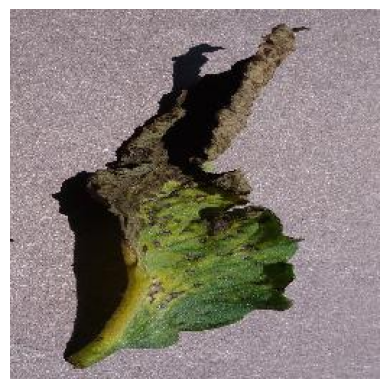

In [7]:
image_path = "/content/PlantVillage/Tomato_Septoria_leaf_spot/0a5edec2-e297-4a25-86fc-78f03772c100___JR_Sept.L.S 8468.JPG"

# Read the image
img = mpimg.imread(image_path)

print(img.shape)
# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

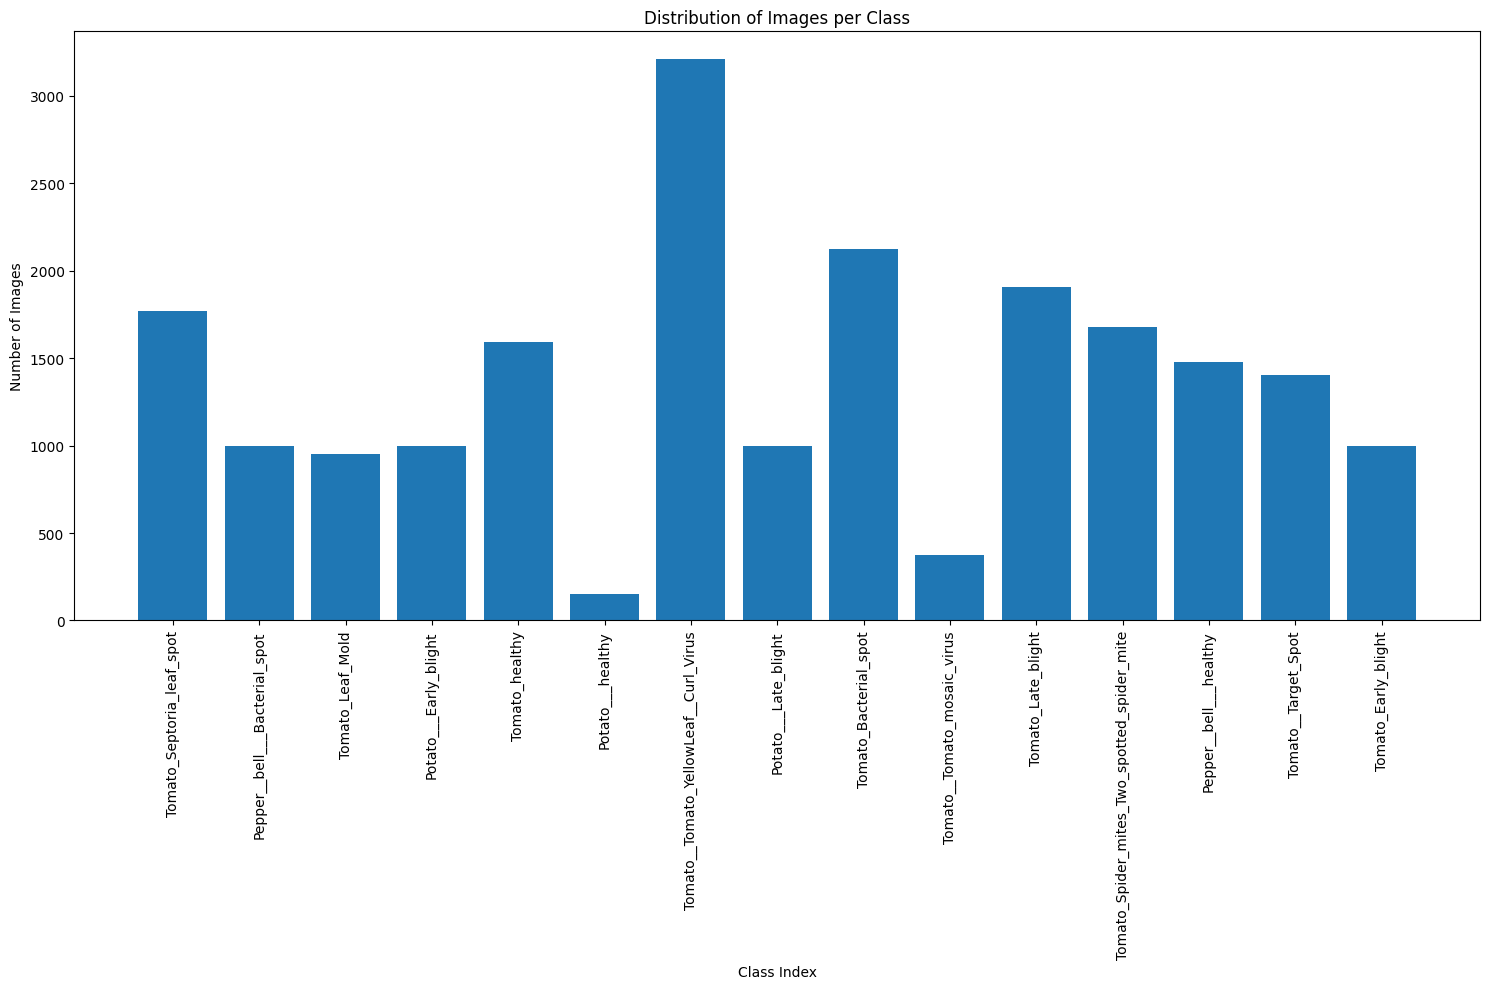

In [8]:
plt.figure(figsize=(15, 10))
plt.bar(range(len(class_counts)), list(class_counts.values()))
plt.xlabel('Class Index')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Class')
plt.xticks(range(len(class_counts)), list(class_counts.keys()), rotation=90)
plt.tight_layout()
plt.show()

DATA PREPROCESSING

In [9]:
#Parameters
img_size = (224, 224)
batchSize = 35
validationSplit = 0.2

In [10]:
train_datagenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=validationSplit
)

In [11]:
train_generator = train_datagenerator.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batchSize,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 16516 images belonging to 15 classes.


In [12]:
validation_generator = train_datagenerator.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batchSize,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 4122 images belonging to 15 classes.


In [13]:
# Test data generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Number of classes: 15
Training samples: 16516
Validation samples: 4122


Building and Training the Model

In [14]:
mobnet_model = MobileNetV2(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        )
resnet_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        )

In [15]:
base_model = mobnet_model
base_model.trainable = False
model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])

In [16]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=0.0001
    )
]

In [18]:
#Training
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3123 - loss: 2.2247
Epoch 1: val_accuracy improved from -inf to 0.73702, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 1202s 3s/step - accuracy: 0.3126 - loss: 2.2236 - val_accuracy: 0.7370 - val_loss: 0.9401 - learning_rate: 1.0000e-04
Epoch 2/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6560 - loss: 1.0817
Epoch 2: val_accuracy improved from 0.73702 to 0.78384, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 1185s 3s/step - accuracy: 0.6561 - loss: 1.0816 - val_accuracy: 0.7838 - val_loss: 0.6971 - learning_rate: 1.0000e-04
Epoch 3/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7240 - loss: 0.8456
Epoch 3: val_accuracy improved from 0.78384 to 0.81611, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 1155s 2s/step - accuracy: 0.7240 - loss: 0.8455 - val_accuracy: 0.8161 - val_loss: 0.5769 - learning_rate: 1.0000e-04
Epoch 4/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7631 - loss: 0.7196
Epoch 4: val_accuracy improved from 0.81611 to 0.83212, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 1147s 2s/step - accuracy: 0.7631 - loss: 0.7196 - val_accuracy: 0.8321 - val_loss: 0.5140 - learning_rate: 1.0000e-04
Epoch 5/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7791 - loss: 0.6721
Epoch 5: val_accuracy improved from 0.83212 to 0.84377, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 1134s 2s/step - accuracy: 0.7791 - loss: 0.6720 - val_accuracy: 0.8438 - val_loss: 0.4774 - learning_rate: 1.0000e-04
Epoch 6/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7984 - loss: 0.6027
Epoch 6: val_accuracy improved from 0.84377 to 0.85614, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 1170s 2s/step - accuracy: 0.7984 - loss: 0.6027 - val_accuracy: 0.8561 - val_loss: 0.4583 - learning_rate: 1.0000e-04
Epoch 7/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8113 - loss: 0.5728
Epoch 7: val_accuracy improved from 0.85614 to 0.86123, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 1138s 2s/step - accuracy: 0.8113 - loss: 0.5728 - val_accuracy: 0.8612 - val_loss: 0.4318 - learning_rate: 1.0000e-04
Epoch 8/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8127 - loss: 0.5538
Epoch 8: val_accuracy did not improve from 0.86123
472/472 ━━━━━━━━━━━━━━━━━━━━ 1137s 2s/step - accuracy: 0.8127 - loss: 0.5538 - val_accuracy: 0.8607 - val_loss: 0.4102 - learning_rate: 1.0000e-04
Epoch 9/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8217 - loss: 0.5331
Epoch 9: val_accuracy improved from 0.86123 to 0.87385, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 1147s 2s/step - accuracy: 0.8217 - loss: 0.5331 - val_accuracy: 0.8738 - val_loss: 0.3890 - learning_rate: 1.0000e-04
Epoch 10/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8274 - loss: 0.5115
Epoch 10: val_accuracy did not improve from 0.87385
472/472 ━━━━━━━━━━━━━━━━━━━━ 1146s 2s/step - accuracy: 0.8274 - loss: 0.5115 - val_accuracy: 0.8736 - val_loss: 0.3835 - learning_rate: 1.0000e-04


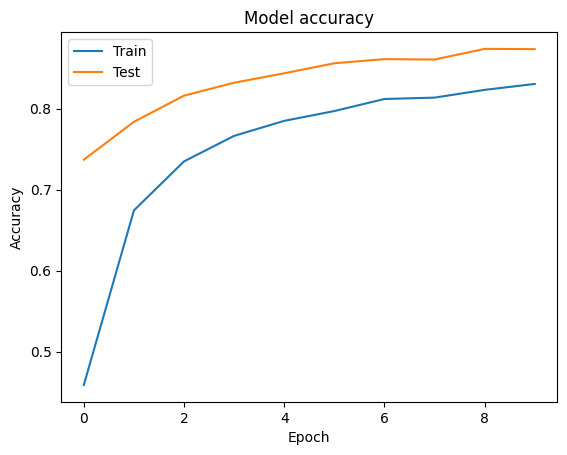

In [21]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

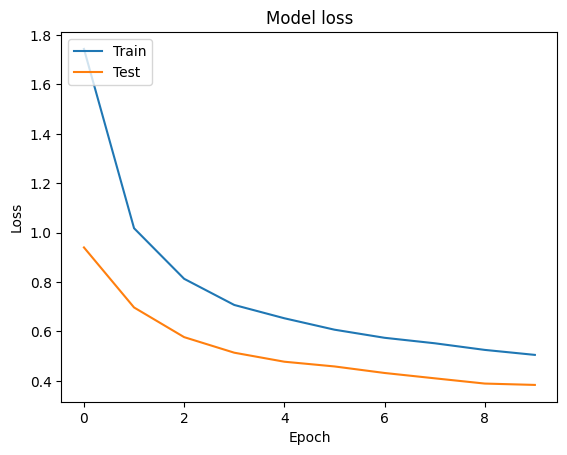

In [22]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Model Evaluation

In [20]:
#Evaluation
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batchSize)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

117/117 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.8924 - loss: 0.3263
Validation Accuracy: 87.74%


In [23]:
# Get true labels and predicted labels
y_true = validation_generator.classes
y_pred_probs = model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

118/118 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step


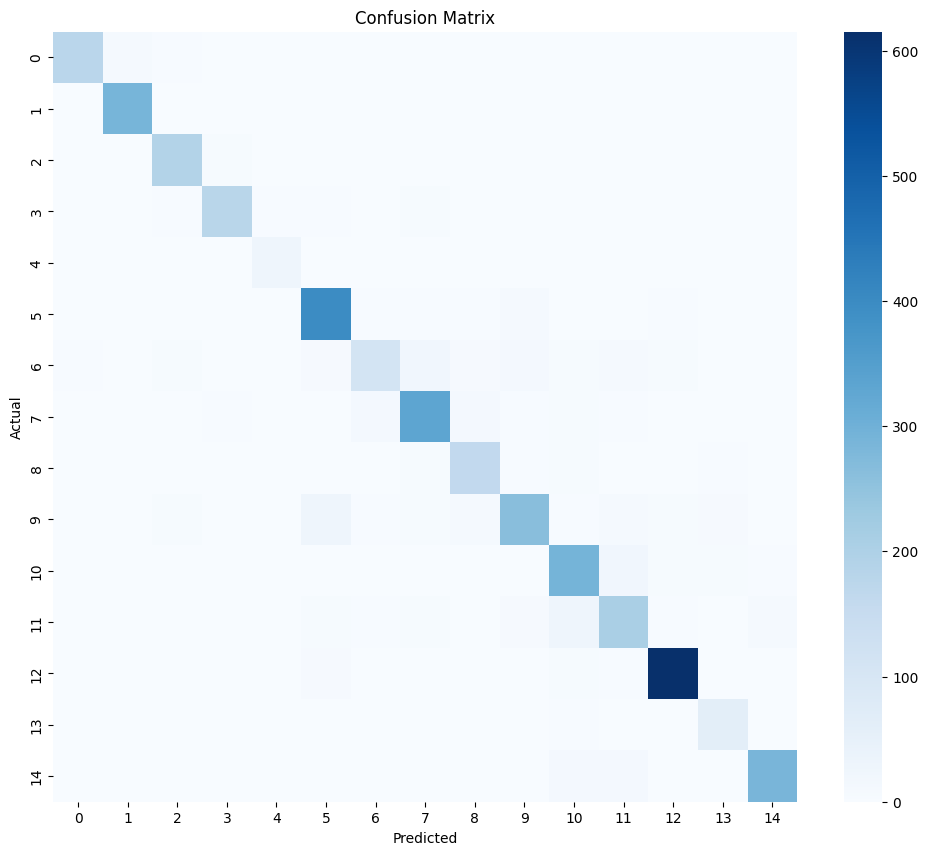

In [24]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [25]:
# Classification Report
class_labels = list(validation_generator.class_indices.keys())
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.94      0.89      0.91       199
                     Pepper__bell___healthy       0.95      0.98      0.97       295
                      Potato___Early_blight       0.90      0.95      0.93       200
                       Potato___Late_blight       0.94      0.90      0.92       200
                           Potato___healthy       0.82      0.90      0.86        30
                      Tomato_Bacterial_spot       0.86      0.93      0.90       425
                        Tomato_Early_blight       0.78      0.56      0.65       200
                         Tomato_Late_blight       0.86      0.87      0.86       381
                           Tomato_Leaf_Mold       0.78      0.86      0.82       190
                  Tomato_Septoria_leaf_spot       0.84      0.75      0.79       354
Tomato_Spider_mites_Two_spotted_spider_m

In [26]:
#Save model
model.save('plant_disease_model.h5')

In [78]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
# Load the trained model
model = load_model('plant_disease_model.h5')

# Class names (same order as in your training generator)
class_indices = validation_generator.class_indices
class_names = list(class_indices.keys())

In [73]:
# Path to your folder with new images
test_folder = '/content/drive/MyDrive/Afarinick Internship/plantvillage_test_images'

# Loop over all images in the folder
for img_file in os.listdir(test_folder):
    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(test_folder, img_file)

        # Load and preprocess image
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Batch size 1
        img_array /= 255.0

        # Predict
        pred_probs = model.predict(img_array)
        pred_class_index = np.argmax(pred_probs, axis=1)[0]
        predicted_label = class_names[pred_class_index]
        confidence = np.max(pred_probs) * 100

        print(f"{img_file}: {predicted_label} ({confidence:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
potato_late-blight_08_zoom-Photo-OMAFRA-900x580.jpeg: Tomato_Late_blight (95.92%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
potato-early-blight-leaves.jpg: Tomato_Septoria_leaf_spot (68.87%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
late_blight_tomato_leaf5x12001-1.jpg: Tomato_Late_blight (98.61%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
bacterial-spot_tomatoes_featured.jpg: Pepper__bell___Bacterial_spot (40.62%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
bls5x2400-10hrvsi.jpg: Pepper__bell___Bacterial_spot (97.13%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
770x540_yellow_leaf_curl.jpg: Tomato_Late_blight (65.24%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
PLB_Halo-2-3-1080x675.jpg: Tomato_Late_blight (90.19%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
PLB_csm_IMG_1341_5793b1e9c4.jpg: Potato___Late_blight (42.16%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
tomato-septoria-leaf-spot.png: Pepper__bell___Bacterial_spot (54.16%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
control-spider-mites

- Most frequent confusion is potato late blight being mistaken with tomato late blight
- Second most frequent confusion is bell pepper and tomato leaf bacterial spots

6 out of 15 images accurately predicted